In [4]:
#pip install sentence-transformers

In [5]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
import json
import langid
from sklearn.feature_extraction.text import TfidfVectorizer
from keybert import KeyBERT
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
from nltk import pos_tag, word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from collections import Counter
import ast

# Download the NLTK data for part-of-speech tagging
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vandi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\vandi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

# Creating the Dataset

## Creating CSV from JSON

In [7]:
json_file=pd.read_json('sm_pads.json', orient='records')

In [8]:
pads_list = json_file['pads']
flattened_data = []

for pad in pads_list:
    flattened_pad = {
        'id': pad['id'],
        'content': pad['content'],
        'is_public': pad['is_public'],
        'tags': '; '.join(pad['tags']),  # Join the list of tags into a string
        'sdgs': '; '.join(pad['sdgs']),  # Join the list of sdgs into a string
        'country': pad['country'],
        'lang': pad['lang']
    }
    flattened_data.append(flattened_pad)

In [9]:
df = pd.DataFrame(flattened_data)
df.head()

,id,content,is_public,tags,sdgs,country,lang
0,4364,Tikikil stove\n\nGIZ\nOffice contact GIZ Offic...,True,clean energy; affordable energy; stove,Good health and well-being; Affordable and cle...,ETH,en
1,4571,Alokito hridoy - enlightening the souls of chi...,True,education,Quality education,BGD,en
2,6099,BioFabricating Materials\nSolution holder: Bat...,False,nature-based solutions; design; sustainable fa...,"Industry, innovation and infrastructure; Respo...",JOR,en
3,6100,Circulamic\nSolution holder: Batoul Al-Rashdan...,False,nature-based solutions; recycling; design; sus...,"Industry, innovation and infrastructure; Respo...",JOR,en
4,4145,Gakyid Ride (City Bus ride app)\nThis app prov...,False,digital platform; innovation challenges; innov...,Good health and well-being; Sustainable cities...,BTN,en


In [10]:
df.dropna(inplace=True)
df.shape
df['tags'] = df['tags'].str.split('; ')
df_explode=df.explode('tags')
tag_distribution = df_explode['tags'].value_counts()
#df['tags'] = df['tags'].apply(ast.literal_eval)

In [11]:
#df_explode = df.explode('tags')

In [12]:
print(df['tags'][0])

['clean energy', 'affordable energy', 'stove']


In [13]:
df_explode.head()

,id,content,is_public,tags,sdgs,country,lang
0,4364,Tikikil stove\n\nGIZ\nOffice contact GIZ Offic...,True,clean energy,Good health and well-being; Affordable and cle...,ETH,en
0,4364,Tikikil stove\n\nGIZ\nOffice contact GIZ Offic...,True,affordable energy,Good health and well-being; Affordable and cle...,ETH,en
0,4364,Tikikil stove\n\nGIZ\nOffice contact GIZ Offic...,True,stove,Good health and well-being; Affordable and cle...,ETH,en
1,4571,Alokito hridoy - enlightening the souls of chi...,True,education,Quality education,BGD,en
2,6099,BioFabricating Materials\nSolution holder: Bat...,False,nature-based solutions,"Industry, innovation and infrastructure; Respo...",JOR,en


In [14]:
df_explode['unique_id'] = range(len(df_explode))
df_explode = df_explode[['unique_id'] + [col for col in df_explode.columns if col != 'unique_id']]
print(df_explode[df_explode['tags'] == 'clean energy'].iloc[0])

unique_id                                                    0
id                                                        4364
content      Tikikil stove\n\nGIZ\nOffice contact GIZ Offic...
is_public                                                 True
tags                                              clean energy
sdgs         Good health and well-being; Affordable and cle...
country                                                    ETH
lang                                                        en
Name: 0, dtype: object


In [15]:
df.to_csv("capstone_data_final.csv")

## Extract Tags from the Content

In [16]:
def remove_non_english_tokens(text):
    '''Remove all non english tokens'''
    # Split the text into tokens

    # Identify the language of each token
    english_tokens = [word for word in text.split() if langid.classify(word)[0] == 'en']

    # Reconstruct the text with English tokens
    filtered_text = ' '.join(english_tokens)

    return filtered_text

In [17]:
def remove_proper_nouns(text):
    '''remove proper nouns such as names of persons'''
    # Tokenize the text into words
    words = word_tokenize(text)

    # Perform part-of-speech tagging
    pos_tags = pos_tag(words)

    # Remove proper nouns (NNP: singular proper noun, NNPS: plural proper noun)
    filtered_words = [word for word, pos in pos_tags if pos not in ['NNP', 'NNPS']]

    # Reconstruct the text without proper nouns
    filtered_text = ' '.join(filtered_words)

    return filtered_text

In [18]:
def remove_emails_and_hyperlinks(text):
    '''remove emails and hyperlinks'''
    # Remove emails
    text_no_emails = re.sub(r'\S+@\S+', '', text)

    # Remove hyperlinks
    text_no_links = re.sub(r'http[s]?\S+', '', text_no_emails,flags=re.IGNORECASE)

    return text_no_links

In [19]:
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

In [20]:
df=pd.read_csv("capstone_data_final.csv")
df=df[df['lang']=='en']

In [21]:
df["clean_content"]=df["content"].apply(remove_non_english_tokens)
df["clean_content"]=df["clean_content"].apply(remove_emails_and_hyperlinks)
df["clean_content"]=df["clean_content"].apply(remove_proper_nouns)
df["clean_content"]=df["clean_content"].apply(remove_numbers)

In [22]:
model = KeyBERT(model="distilbert-base-nli-mean-tokens")

# Function to extract keywords (tags) for each text
def extract_tags(text, top_n=5,keyprob=False):
    '''extract top keywords based on the parameter given by user'''
    keywords = model.extract_keywords(text,top_n=top_n)
    return [keyword[0] for keyword in keywords if keyword[1]>=0.1]

# Apply the extract_tags function to each text in the DataFrame
df["tags_keybert"] = df["clean_content"].apply(lambda text: extract_tags(text, top_n=20,keyprob=True))

In [23]:
df.to_csv("keybert_thresh_onlyen_0.1_nltk.csv")

##  Semantic clustering of the tags (user assigned + KeyBERT) using SBERT + Root word generation loop

In [24]:
def cluster_creation(combined_df):
    combined_df_explode = combined_df.explode('combined_tags')
    combined_df_explode['unique_id'] = range(len(combined_df_explode))
    combined_df_explode = combined_df_explode[['unique_id'] + [col for col in combined_df_explode.columns if col != 'unique_id']]
    combined_df_explode.set_index('unique_id', inplace=True)
    combined_df_explode = combined_df_explode.applymap(lambda s: s.lower() if type(s) == str else s)
    embedder = SentenceTransformer('all-MiniLM-L6-v2')
    combined_corpus = combined_df_explode['combined_tags'].unique()
    combined_corpus = list(combined_corpus)
    combined_corpus_embeddings = embedder.encode(combined_corpus, show_progress_bar=True)
    combined_corpus_embeddings = combined_corpus_embeddings /  np.linalg.norm(combined_corpus_embeddings, axis=1, keepdims=True)
    combined_clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold = 0.75, metric='cosine', linkage='average')
    combined_clustering_model.fit(combined_corpus_embeddings)
    combined_cluster_assignment = combined_clustering_model.labels_
    combined_clustered_sentences = {}
    for sentence_id, cluster_id in enumerate(combined_cluster_assignment):
        if cluster_id not in combined_clustered_sentences:
            combined_clustered_sentences[cluster_id] = []

        combined_clustered_sentences[cluster_id].append(combined_corpus[sentence_id])
    #print(combined_clustered_sentences)
    sbert_clusters = {key: [str(value).strip("'") for value in values] for key, values in combined_clustered_sentences.items()}
    return sbert_clusters

In [25]:
import spacy
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

nlp = spacy.load("en_core_web_md")
def central_word_cossim(row):
    # Calculate aggregated vector
    #vectors = [nlp(word).vector for word in words]
    
    ####Normalize first before mean, then cos_sim not required
    
    
    aggregated_vector = sum(nlp(word).vector/len(nlp(word).vector) for word in row) / len(row)
    #print(aggregated_vector)
    
    #Reshape to 2-D
    #word = word.reshape(1, -1)
    aggregated_vector = aggregated_vector.reshape(1, -1)
    
    
    # Calculate similarity between aggregated vector and each word vector
    similarities = [cosine_similarity(aggregated_vector, nlp(word).vector.reshape(1,-1)) for word in row]
    

    # Select the word with the highest similarity
    central_word_index = np.argmax(similarities)
    return row[central_word_index]

#cluster_df["keywords_glove_lemm"]=cluster_df['tags_lemmatized'].apply(lambda row: central_word_cossim(row))

In [26]:
def root_word_gen(sbert_clusters):
    #print(sbert_clusters)
    dict_df={"cluster":sbert_clusters.keys(),"tags":sbert_clusters.values()}
    tags_cluster=[]
    for i in dict_df["tags"]:
        tags=[]
        for j in i:
            if " " in j:
                j=j.split()
                for k in j:
                    tags.append(k)
            else:
                tags.append(j)
        tags_cluster.append(tags)
    cluster_df=pd.DataFrame.from_dict(dict_df)
    cluster_df["keywords_glove"]=cluster_df['tags'].apply(lambda row: central_word_cossim(row))
    cluster_dict = {}
    for i,data in cluster_df.iterrows():
        cluster_dict[data['keywords_glove']] = data['tags']
    #print(cluster_dict)
    
    return cluster_dict

In [27]:
def map_tags_to_clusters(tag_list):
    clusters = []
    for key, value in cluster_dict.items():
        for tag in tag_list:
            if tag in value:
                clusters.append(key)
        
    #clusters = [key for key, value in sbert_clusters.items() if any(tag in value for tag in tag_list)]
    return clusters


In [29]:
df_orig = pd.read_csv("capstone_data_final.csv")

In [30]:
num_clusters = 100
combined_df = pd.read_csv("keybert_thresh_onlyen_0.1_nltk.csv")
combined_df['tags'] = combined_df['tags'].apply(ast.literal_eval)
combined_df['tags_keybert'] = combined_df['tags_keybert'].apply(ast.literal_eval)
combined_df['combined_tags'] = combined_df['tags'] + combined_df['tags_keybert']
df_orig_loop = df_orig.copy()
df_orig_loop.to_csv("clusters_master_df.csv")
num = 1
while num_clusters > 50:
    sbert_clusters = cluster_creation(combined_df)
    num_clusters = len(sbert_clusters.keys())
    print("clusters created")
    print(num_clusters)
    cluster_dict = root_word_gen(sbert_clusters)
    print("generated root word")
    df_orig = combined_df.copy()
    df_orig['tag_clusters'] = df_orig['combined_tags'].apply(map_tags_to_clusters)
    print('tag clusters mapped')
    df_orig.to_csv("clusters_master_df_"+str(num)+".csv")
    num+=1
    combined_df = df_orig[["tag_clusters"]]
    combined_df = combined_df.rename(columns={"tag_clusters": "combined_tags"})
    print('new df created')

Batches:   0%|          | 0/188 [00:00<?, ?it/s]

clusters created
110
generated root word
tag clusters mapped
new df created


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

clusters created
40
generated root word
tag clusters mapped
new df created


In [32]:
left = pd.read_csv("clusters_master_df_"+str(1)+".csv")
for i in range(1,num-1):
    right = pd.read_csv("clusters_master_df_"+str(i+1)+".csv")
    df_cluster = left.merge(right, how = "inner", left_on="tag_clusters", right_on="combined_tags")
    left = df_cluster.drop(["tag_clusters_x","combined_tags_y"],axis=1)
    left = left.rename({"tag_clusters_y":"tag_clusters"},axis=1)

In [33]:
left

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0_x,id,content,is_public,tags,sdgs,country,lang,clean_content,tags_keybert,combined_tags_x,Unnamed: 0_y,tag_clusters
0,0,0,0,4364,Tikikil stove\n\nGIZ\nOffice contact GIZ Offic...,True,"['clean energy', 'affordable energy', 'stove']",Good health and well-being; Affordable and cle...,ETH,en,"stove contact address , -- -- stove is used f...","['stove', 'firewood', 'cooking', 'combustion',...","['clean energy', 'affordable energy', 'stove',...",0,"['wind energy', 'wind energy', 'cooking stove'..."
1,1,1,1,4571,Alokito hridoy - enlightening the souls of chi...,True,['education'],Quality education,BGD,en,hridoy - the souls of children ( meaning soul ...,"['teachers', 'teacher', 'training', 'education...","['education', 'teachers', 'teacher', 'training...",1,"['investments', 'knowledge management', 'knowl..."
2,2,2,2,6099,BioFabricating Materials\nSolution holder: Bat...,False,"['nature-based solutions', 'design', 'sustaina...","Industry, innovation and infrastructure; Respo...",JOR,en,BioFabricating Materials holder : In this last...,"['biofabricating', 'plastics', 'crafting', 'te...","['nature-based solutions', 'design', 'sustaina...",2,"['chemical', 'chemical', 'mating', 'optimizati..."
3,3,3,3,6100,Circulamic\nSolution holder: Batoul Al-Rashdan...,False,"['nature-based solutions', 'recycling', 'desig...","Industry, innovation and infrastructure; Respo...",JOR,en,Circulamic holder : by is a clever way to add ...,"['customizable', 'tools', 'acoustics', 'lab', ...","['nature-based solutions', 'recycling', 'desig...",3,"['chemical', 'chemical', 'mating', 'optimizati..."
4,4,4,4,4145,Gakyid Ride (City Bus ride app)\nThis app prov...,False,"['digital platform', 'innovation challenges', ...",Good health and well-being; Sustainable cities...,BTN,en,( ride app ) This app provides commuters with ...,"['bus', 'buses', 'traffic', 'commuters']","['digital platform', 'innovation challenges', ...",4,"['wind energy', 'mating', 'mating', 'mating', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2876,2774,3382,3382,6083,Container Filter\n\nFilter to capture cediment...,False,"['climate change', 'clean water']",Clean water and sanitation; Responsible consum...,GTM,en,to capture in the water stored in the rotopla ...,"['tanks', 'water', 'stored', 'rotopla', 'captu...","['climate change', 'clean water', 'tanks', 'wa...",2774,"['bar', 'chemical', 'chemical', 'mating', 'mat..."
2877,2775,3383,3383,6084,Galvanized gutter\n\nGalvanized gutter for wat...,False,"['climate change', 'clean water']",Clean water and sanitation; Responsible consum...,GTM,en,for water transport .,"['water', 'transport']","['climate change', 'clean water', 'water', 'tr...",2775,"['bar', 'chemical', 'chemical', 'mating']"
2878,2776,3384,3384,6085,Iron Gutter\n\nGalvanized gutter for water tra...,False,"['climate change', 'clean water', 'rain water ...",Clean water and sanitation; Responsible consum...,GTM,en,for water transport,"['water', 'transport']","['climate change', 'clean water', 'rain water ...",2776,"['bar', 'chemical', 'chemical', 'chemical', 'm..."
2879,2777,3386,3386,6089,PVC pipe for rain descent\n\nPVC pipe for rain...,False,"['climate change', 'clean water', 'water mobil...",Clean water and sanitation; Responsible consum...,GTM,en,pipe for rain descent pipe for rain descent . ...,"['pipe', 'rain', 'cross', 'descent', 'section'...","['climate change', 'clean water', 'water mobil...",2777,"['bar', 'chemical', 'chemical', 'chemical', 'c..."


## Co-occurence of Clusters

In [34]:
correlation_matrix = np.zeros((num_clusters, num_clusters), dtype=int)
document_counts = np.zeros(num_clusters, dtype=int)
clusters = list(cluster_dict.keys())
left['tag_clusters'] = left['tag_clusters'].apply(ast.literal_eval)
for tags in left['tag_clusters']:
    #print(tags)
    for tag in tags:
        cluster_index = clusters.index(tag)
        document_counts[cluster_index] += 1
    
    # Update the matrix based on the co-occurrence of clusters in each row
    for i in range(len(tags)):
        for j in range(i + 1, len(tags)):
            # Find the indices of the clusters in the matrix
            index_i = clusters.index(tags[i])
            index_j = clusters.index(tags[j])

            # Update the matrix
            correlation_matrix[index_i, index_j] += 1
            correlation_matrix[index_j, index_i] += 1

# Create a DataFrame from the matrix
correlation_df = pd.DataFrame(correlation_matrix, columns=clusters, index=clusters)

# Normalize the correlation_df
for i in range(len(correlation_df.index)):
    for j in range(i + 1, len(correlation_df.columns)):
        denominator = document_counts[i] + document_counts[j]
        if denominator > 0:
            correlation_df.iloc[i, j] /= denominator
            correlation_df.iloc[j, i] /= denominator

print("Correlation Matrix:")
correlation_df

Correlation Matrix:


,wind energy,cooking stove,sapling,bar,chemical,mating,investments,optimization,lowers,page,knowledge management,en,month,affordable electronic devices,acculturation,modular,preventing,covid-19,community involvement,digital forms sharing information,lack,validation,medically,integrating,enviromental mapping,logs,called,nan,active citizenship,informal employment,prebiotics,vice,inequalities,flaking,iwartjqqnnaigquxcclhqjauhsjrcdokxzxlidvh_ckqzew_dplw,thermoelectric,islets,sdg localization,bootcamp,hydroxyapatite
wind energy,2672.000000,0.554261,0.313495,0.293519,0.446747,0.380988,0.260208,0.261538,0.065460,0.139394,0.307458,0.061021,0.098140,0.236388,0.388659,0.136448,0.161990,0.026879,0.247598,0.114689,0.062567,0.039847,0.115789,0.008121,0.023335,0.006429,0.022910,0.011507,0.016148,0.024090,0.020525,0.002341,0.002345,0.007593,0.000000,0.001179,0.003511,0.000000,0.000000,0.000000
cooking stove,0.554261,6358.000000,0.458155,0.258076,0.535321,0.381841,0.261200,0.116592,0.069617,0.056003,0.194602,0.043778,0.083656,0.124312,0.244518,0.072799,0.127273,0.028491,0.231537,0.067528,0.058941,0.014257,0.122058,0.004310,0.016411,0.001628,0.014909,0.011765,0.001608,0.030000,0.053552,0.001630,0.002176,0.002711,0.004376,0.000000,0.004345,0.000000,0.000000,0.000547
sapling,0.313495,0.458155,2714.000000,0.272841,0.414764,0.342802,0.275340,0.187682,0.041641,0.101391,0.242372,0.085801,0.060947,0.145334,0.298732,0.131002,0.140091,0.009075,0.269497,0.076695,0.068350,0.014502,0.113199,0.010149,0.016545,0.004096,0.011333,0.028820,0.005376,0.045623,0.020557,0.000684,0.002740,0.010914,0.000690,0.000000,0.004785,0.000000,0.000000,0.000690
bar,0.293519,0.258076,0.272841,1750.000000,0.301804,0.290198,0.116436,0.266401,0.110044,0.117174,0.164268,0.051414,0.087354,0.127305,0.242074,0.080532,0.190820,0.021176,0.161986,0.068493,0.049296,0.022769,0.059720,0.004040,0.045943,0.009212,0.025692,0.007968,0.021000,0.050265,0.009804,0.002051,0.007202,0.010225,0.001040,0.000000,0.015385,0.000000,0.000000,0.001041
chemical,0.446747,0.535321,0.414764,0.301804,11376.000000,0.628800,0.374051,0.329937,0.075632,0.153192,0.372712,0.068742,0.065679,0.211398,0.511008,0.116932,0.247963,0.049721,0.331341,0.125999,0.092118,0.027623,0.145021,0.014851,0.022991,0.007582,0.013212,0.013240,0.006237,0.030387,0.019131,0.005231,0.000262,0.006796,0.000262,0.000262,0.005231,0.000000,0.000000,0.000525
mating,0.380988,0.381841,0.342802,0.290198,0.628800,8846.000000,0.516850,0.411989,0.076606,0.248826,0.598088,0.066427,0.095831,0.372755,0.660062,0.178365,0.311711,0.086099,0.637124,0.176553,0.080662,0.051697,0.188429,0.012896,0.022636,0.004314,0.041132,0.015792,0.016345,0.088464,0.018657,0.007553,0.005130,0.009164,0.000271,0.000541,0.006474,0.000541,0.000000,0.000000
investments,0.260208,0.261200,0.275340,0.116436,0.374051,0.516850,3674.000000,0.317158,0.069540,0.352161,0.468468,0.077519,0.086232,0.414744,0.478699,0.211183,0.261636,0.081952,0.542905,0.213992,0.048697,0.073183,0.111899,0.020138,0.023438,0.002134,0.017287,0.024198,0.014233,0.125062,0.030777,0.008013,0.005350,0.004267,0.000538,0.002152,0.000534,0.000000,0.000000,0.000000
optimization,0.261538,0.116592,0.187682,0.266401,0.329937,0.411989,0.317158,1818.000000,0.099257,0.417910,0.545501,0.111776,0.113134,0.406409,0.596874,0.220522,0.298901,0.103662,0.476088,0.283574,0.082201,0.089261,0.148204,0.030920,0.072848,0.015232,0.030415,0.014925,0.047904,0.062585,0.026549,0.006865,0.004587,0.006088,0.000000,0.000770,0.004577,0.000770,0.000771,0.000000
lowers,0.065460,0.069617,0.041641,0.110044,0.075632,0.076606,0.069540,0.099257,38.000000,0.046584,0.058887,0.040816,0.039813,0.062845,0.099615,0.087289,0.079038,0.018000,0.050147,0.050132,0.066482,0.021672,0.072748,0.004651,0.040323,0.004950,0.025316,0.030568,0.013333,0.033426,0.024490,0.000000,0.000000,0.000000,0.000000,0.000000,0.005000,0.000000,0.000000,0.000000
page,0.139394,0.056003,0.101391,0.117174,0.153192,0.248826,0.352161,0.417910,0.046584,720.000000,0.347206,0.101215,0.085044,0.44618

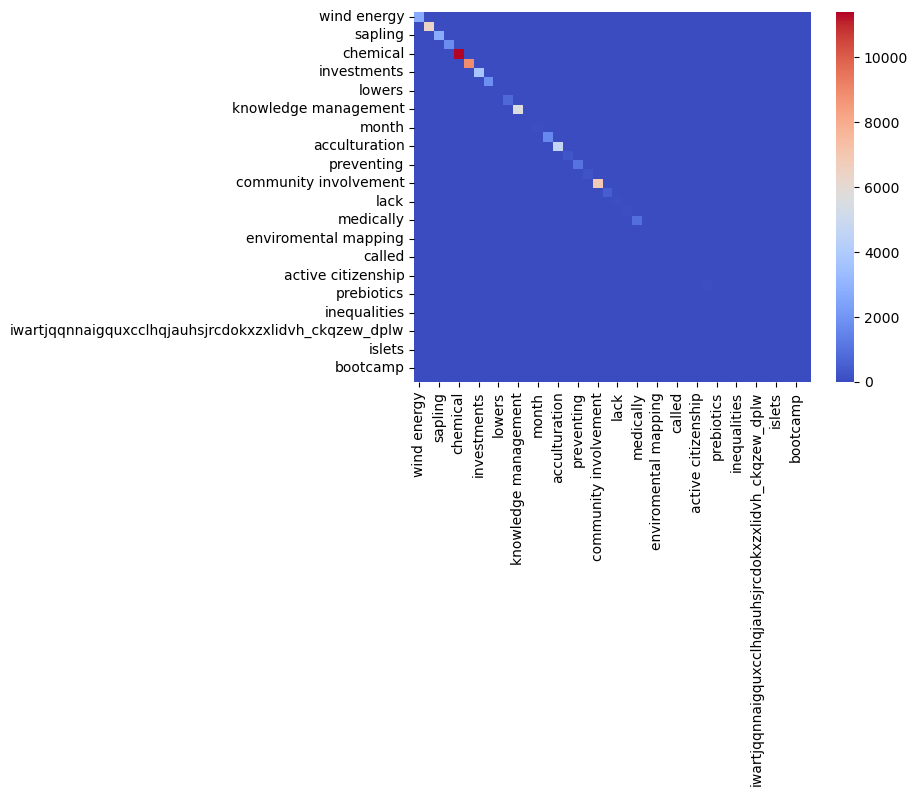

In [35]:
sns.heatmap(correlation_df, annot=False, cmap="coolwarm", linewidths=0)
plt.show()